# Real-Time Conference Registration Forecasting System

This notebook provides real-time forecasting of conference registrations with comprehensive analysis and external factor integration.

**Key Features:**
- **Real-time predictions**: Uses current registration data to predict final totals
- **Confidence intervals**: Provides conservative, likely, and optimistic estimates  
- **Historical pattern matching**: Leverages cleaned datasets from multiple audiences
- **External factor integration**: Accounts for UK bank holidays and COVID-like disruptions
- **Streamlined dashboard**: Clean visualization showing accurate weekly registration trends
- **Actionable insights**: Provides specific recommendations and weekly targets

In [1]:
# Install and import required libraries
import subprocess
import sys

def install_package(package):
    """Install a package using pip"""
    try:
        subprocess.check_call([sys.executable, "-m", "pip", "install", package])
        print(f"✓ Successfully installed {package}")
    except subprocess.CalledProcessError:
        print(f"✗ Failed to install {package}")

# Required packages - only those actually used in the code
required_packages = ["pandas", "numpy", "matplotlib", "scipy"]

print("Checking and installing dependencies...")
for package in required_packages:
    try:
        __import__(package.replace("-", "_"))
        print(f"✓ {package} already installed")
    except ImportError:
        print(f"Installing {package}...")
        install_package(package)

print("\nDependency check complete!")

Checking and installing dependencies...
Installing pandas...
  Using cached pandas-2.3.1-cp311-cp311-macosx_10_9_x86_64.whl.metadata (91 kB)
  Using cached numpy-2.3.1-cp311-cp311-macosx_14_0_x86_64.whl.metadata (62 kB)
  Using cached pytz-2025.2-py2.py3-none-any.whl.metadata (22 kB)
  Using cached tzdata-2025.2-py2.py3-none-any.whl.metadata (1.4 kB)
Using cached pandas-2.3.1-cp311-cp311-macosx_10_9_x86_64.whl (11.6 MB)
Using cached numpy-2.3.1-cp311-cp311-macosx_14_0_x86_64.whl (6.9 MB)
Using cached pytz-2025.2-py2.py3-none-any.whl (509 kB)
Using cached tzdata-2025.2-py2.py3-none-any.whl (347 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4/4 [pandas]2m3/4 [pandas]
✓ Successfully installed pandas
✓ numpy already installed
Installing matplotlib...
  Using cached matplotlib-3.10.3-cp311-cp311-macosx_10_12_x86_64.whl.metadata (11 kB)
  Using cached contourpy-1.3.2-cp311-cp311-macosx_10_9_x86_64.whl.metadata (5.5 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using

In [2]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import os
from datetime import datetime
import warnings
from typing import Dict, List

warnings.filterwarnings('ignore')
plt.style.use('default')
plt.rcParams['figure.figsize'] = (15, 10)

In [3]:
# =============================================================================
# USER INPUT INTERFACE
# =============================================================================

def get_user_inputs():
    """Get user inputs for forecasting parameters."""
    print("=" * 60)
    print("REAL-TIME CONFERENCE REGISTRATION FORECASTING")
    print("=" * 60)
    
    # Configuration - using all historical data for better training
    target_audience = "All Audiences"
    use_all_data = True
    event_date = "15/08/2025"
    marketing_start_date = "01/07/2025"
    
    print(f"\nSelected: {target_audience}")
    print(f"Event date: {event_date}")
    print(f"Marketing start: {marketing_start_date}")
    
    return {
        'target_audience': target_audience,
        'use_all_data': use_all_data,
        'event_date': event_date,
        'marketing_start_date': marketing_start_date,
        'current_date': datetime.now().strftime("%d/%m/%Y")
    }

# Get user inputs
user_config = get_user_inputs()

REAL-TIME CONFERENCE REGISTRATION FORECASTING

Selected: All Audiences
Event date: 15/08/2025
Marketing start: 01/07/2025


In [4]:
# =============================================================================
# DATA LOADING AND PROCESSING 
# =============================================================================

def parse_date(date_str: str) -> datetime:
    """Parse date string in DD/MM/YYYY format"""
    try:
        return datetime.strptime(date_str.strip(), "%d/%m/%Y")
    except ValueError:
        try:
            return datetime.strptime(date_str.strip(), "%Y-%m-%d")
        except ValueError:
            return None

def load_current_registrations() -> pd.DataFrame:
    """Load current registration data from sample_data.csv"""
    try:
        df = pd.read_csv('sample_data.csv')
        df['CreatedDate'] = df['Created Date'].apply(parse_date)
        df = df.dropna(subset=['CreatedDate'])
        return df
    except Exception as e:
        print(f"Error loading current registrations: {e}")
        return pd.DataFrame()

def load_historical_patterns(target_audience: str, use_all_data: bool) -> Dict:
    """Load historical patterns from cleaned datasets."""
    base_path = "CONF. DATASET"
    
    if not os.path.exists(base_path):
        return {'error': f'Dataset directory "{base_path}" not found'}
    
    audience_folders = {
        "Education Managers": "Education Managers",
        "Education property managers": "Education property managers", 
        "IT MANAGER": "IT MANAGER",
        "Property Managers": "Property Managers"
    }
    
    events = []
    
    if use_all_data:
        folders_to_check = list(audience_folders.values())
    else:
        if target_audience in audience_folders:
            folders_to_check = [audience_folders[target_audience]]
        else:
            return {'error': f'Unknown target audience: {target_audience}'}
    
    for folder in folders_to_check:
        folder_path = os.path.join(base_path, folder)
        cleaned_file = os.path.join(folder_path, "Cleaned_Dataset.csv")
        
        if os.path.exists(cleaned_file):
            try:
                df = pd.read_csv(cleaned_file)
                if 'SourceFile' in df.columns:
                    df = df.drop('SourceFile', axis=1)
                
                if 'CreatedDate' in df.columns:
                    df['CreatedDate'] = df['CreatedDate'].apply(parse_date)
                    df = df.dropna(subset=['CreatedDate'])
                    
                    if len(df) > 0:
                        df = df.sort_values('CreatedDate')
                        start_date = df['CreatedDate'].min()
                        end_date = df['CreatedDate'].max()
                        
                        # Use 1-based week numbering (Week 1, 2, 3...)
                        df['WeeksSinceStart'] = (df['CreatedDate'] - start_date).dt.days // 7 + 1
                        weekly_counts = df.groupby('WeeksSinceStart').size().reset_index()
                        weekly_counts.columns = ['Week', 'Registrations']
                        
                        if len(weekly_counts) > 0:
                            max_week = weekly_counts['Week'].max()
                            all_weeks = pd.DataFrame({'Week': range(1, max_week + 1)})
                            weekly_counts = all_weeks.merge(weekly_counts, on='Week', how='left').fillna(0)
                        
                        weekly_counts['CumulativeRegistrations'] = weekly_counts['Registrations'].cumsum()
                        
                        event_data = {
                            'audience': folder,
                            'total_registrations': len(df),
                            'duration_weeks': int(weekly_counts['Week'].max()) if len(weekly_counts) > 0 else 0,
                            'weekly_data': weekly_counts,
                            'date_range': f"{start_date.strftime('%d/%m/%Y')} to {end_date.strftime('%d/%m/%Y')}"
                        }
                        
                        events.append(event_data)
                
            except Exception as e:
                continue
    
    if len(events) == 0:
        return {'error': 'No valid historical patterns found'}
    
    return {
        'events': events,
        'total_events': len(events),
        'audiences_covered': list(set([e['audience'] for e in events]))
    }

def calculate_date_info(event_date: str, marketing_start_date: str, current_date: str) -> Dict:
    """Calculate date-related information for forecasting"""
    try:
        event_dt = parse_date(event_date)
        marketing_start_dt = parse_date(marketing_start_date)
        current_dt = parse_date(current_date)
        
        if None in [event_dt, marketing_start_dt, current_dt]:
            return {'error': 'Invalid date format. Use DD/MM/YYYY'}
        
        total_days = (event_dt - marketing_start_dt).days
        elapsed_days = (current_dt - marketing_start_dt).days
        remaining_days = (event_dt - current_dt).days
        
        # Use 1-based week numbering
        weeks_elapsed = elapsed_days // 7 + 1
        weeks_remaining = max(0, remaining_days // 7)
        total_weeks = total_days // 7 + 1
        
        completion_percentage = (elapsed_days / max(total_days, 1)) * 100
        
        return {
            'marketing_start': marketing_start_dt,
            'event_date': event_dt,
            'current_date': current_dt,
            'total_days': total_days,
            'elapsed_days': elapsed_days,
            'remaining_days': remaining_days,
            'weeks_elapsed': weeks_elapsed,
            'weeks_remaining': weeks_remaining,
            'total_weeks': total_weeks,
            'completion_percentage': completion_percentage
        }
        
    except Exception as e:
        return {'error': f'Date calculation error: {e}'}

# Load data
print("Loading data...")
current_registrations = load_current_registrations()
historical_analysis = load_historical_patterns(user_config['target_audience'], user_config['use_all_data'])
date_info = calculate_date_info(user_config['event_date'], user_config['marketing_start_date'], user_config['current_date'])

# Summary
print(f"✓ Loaded {len(current_registrations)} current registrations")
if 'error' not in historical_analysis:
    print(f"✓ Loaded {historical_analysis['total_events']} historical patterns")
if 'error' not in date_info:
    print(f"✓ Campaign: Week {date_info['weeks_elapsed']}, {date_info['weeks_remaining']} weeks remaining")

Loading data...
✓ Loaded 179 current registrations
✓ Loaded 4 historical patterns
✓ Campaign: Week 4, 3 weeks remaining


In [5]:
# =============================================================================
# CURRENT REGISTRATION ANALYSIS
# =============================================================================

def analyze_current_registrations(df: pd.DataFrame, marketing_start: datetime) -> Dict:
    """Analyze current registration patterns."""
    if len(df) == 0:
        return {'error': 'No current registration data available'}
    
    df = df.copy()
    # Use 1-based week numbering (Week 1, 2, 3...)
    df['WeeksSinceStart'] = (df['CreatedDate'] - marketing_start).dt.days // 7 + 1
    
    weekly_counts = df.groupby('WeeksSinceStart').size().reset_index()
    weekly_counts.columns = ['Week', 'Registrations']
    
    if len(weekly_counts) > 0:
        max_week = weekly_counts['Week'].max()
        min_week = weekly_counts['Week'].min()
        all_weeks = pd.DataFrame({'Week': range(min_week, max_week + 1)})
        weekly_counts = all_weeks.merge(weekly_counts, on='Week', how='left').fillna(0)
    
    weekly_counts['CumulativeRegistrations'] = weekly_counts['Registrations'].cumsum()
    
    total_registrations = len(df)
    avg_daily_rate = total_registrations / max(1, (datetime.now() - marketing_start).days)
    avg_weekly_rate = avg_daily_rate * 7
    
    if len(weekly_counts) >= 2:
        recent_weeks = weekly_counts.tail(2)
        recent_velocity = recent_weeks['Registrations'].mean()
    else:
        recent_velocity = weekly_counts['Registrations'].mean() if len(weekly_counts) > 0 else 0
    
    return {
        'weekly_data': weekly_counts,
        'total_registrations': total_registrations,
        'avg_weekly_rate': avg_weekly_rate,
        'recent_velocity': recent_velocity,
        'registration_dates': {
            'first': df['CreatedDate'].min(),
            'last': df['CreatedDate'].max(),
            'span_days': (df['CreatedDate'].max() - df['CreatedDate'].min()).days
        }
    }

# Analyze current registrations
current_analysis = analyze_current_registrations(current_registrations, date_info['marketing_start'])

if 'error' not in current_analysis:
    print(f"\nCurrent Registration Summary:")
    print(f"  Total registrations: {current_analysis['total_registrations']}")
    print(f"  Weekly breakdown:")
    for _, row in current_analysis['weekly_data'].iterrows():
        week = int(row['Week'])
        registrations = int(row['Registrations'])
        cumulative = int(row['CumulativeRegistrations'])
        print(f"    Week {week}: {registrations} new (Total: {cumulative})")
else:
    print(f"Error in current analysis: {current_analysis['error']}")


Current Registration Summary:
  Total registrations: 179
  Weekly breakdown:
    Week 1: 64 new (Total: 64)
    Week 2: 80 new (Total: 144)
    Week 3: 35 new (Total: 179)


In [6]:
# =============================================================================
# ENHANCED PATTERN MATCHING WITH EXTERNAL FACTORS
# =============================================================================

def get_uk_bank_holidays(year: int) -> List[datetime]:
    """Get UK bank holidays for a given year."""
    holidays = [
        datetime(year, 1, 1),   # New Year's Day
        datetime(year, 4, 15),  # Good Friday (approximate)
        datetime(year, 4, 18),  # Easter Monday (approximate)
        datetime(year, 5, 2),   # Early May Bank Holiday
        datetime(year, 5, 30),  # Spring Bank Holiday
        datetime(year, 8, 29),  # Summer Bank Holiday
        datetime(year, 12, 25), # Christmas Day
        datetime(year, 12, 26)  # Boxing Day
    ]
    return holidays

def analyze_external_factors(df: pd.DataFrame) -> Dict:
    """Analyze external factors impact on registration data."""
    if len(df) == 0:
        return {'error': 'No data available'}
    
    try:
        # Parse dates
        df_copy = df.copy()
        if 'CreatedDate' in df_copy.columns:
            df_copy['CreatedDate'] = df_copy['CreatedDate'].apply(parse_date)
            df_copy = df_copy.dropna(subset=['CreatedDate'])
            
            if len(df_copy) == 0:
                return {'error': 'No valid dates found'}
            
            # Basic analysis
            start_date = df_copy['CreatedDate'].min()
            end_date = df_copy['CreatedDate'].max()
            total_days = (end_date - start_date).days + 1
            baseline_daily_rate = len(df_copy) / max(total_days, 1)
            
            # Simple COVID impact analysis (2020-2022 periods)
            covid_periods = {
                '2020_lockdown': len(df_copy[(df_copy['CreatedDate'] >= datetime(2020, 3, 1)) & 
                                           (df_copy['CreatedDate'] <= datetime(2020, 6, 30))]),
                '2021_restrictions': len(df_copy[(df_copy['CreatedDate'] >= datetime(2021, 1, 1)) & 
                                               (df_copy['CreatedDate'] <= datetime(2021, 7, 31))])
            }
            
            # Holiday impact analysis
            years = range(start_date.year, end_date.year + 1)
            holiday_impact = {}
            
            for year in years:
                holidays = get_uk_bank_holidays(year)
                for i, holiday in enumerate(holidays):
                    # Check registrations around holiday (±3 days)
                    holiday_start = holiday - pd.Timedelta(days=3)
                    holiday_end = holiday + pd.Timedelta(days=3)
                    holiday_regs = len(df_copy[(df_copy['CreatedDate'] >= holiday_start) & 
                                             (df_copy['CreatedDate'] <= holiday_end)])
                    
                    expected_regs = baseline_daily_rate * 7
                    impact_ratio = holiday_regs / max(expected_regs, 1) if expected_regs > 0 else 1.0
                    
                    holiday_impact[f'{year}_holiday_{i}'] = {
                        'registrations': holiday_regs,
                        'impact_ratio': impact_ratio
                    }
            
            return {
                'baseline_daily_rate': baseline_daily_rate,
                'covid_impact': covid_periods,
                'holiday_impact': holiday_impact,
                'total_registrations': len(df_copy),
                'date_range': f"{start_date.strftime('%Y-%m-%d')} to {end_date.strftime('%Y-%m-%d')}"
            }
        else:
            return {'error': 'CreatedDate column not found'}
            
    except Exception as e:
        return {'error': f'Analysis failed: {str(e)}'}

def analyze_historical_patterns_with_external_factors(historical_data: Dict) -> Dict:
    """Analyze historical patterns for external factor impacts."""
    if 'error' in historical_data:
        return {'error': 'No historical data available'}
    
    enhanced_patterns = []
    
    for pattern in historical_data['events']:
        audience = pattern['audience']
        folder_path = os.path.join("CONF. DATASET", audience)
        cleaned_file = os.path.join(folder_path, "Cleaned_Dataset.csv")
        
        if os.path.exists(cleaned_file):
            try:
                df = pd.read_csv(cleaned_file)
                if 'SourceFile' in df.columns:
                    df = df.drop('SourceFile', axis=1)
                
                external_analysis = analyze_external_factors(df)
                enhanced_pattern = pattern.copy()
                enhanced_pattern['external_factors'] = external_analysis
                
                if 'error' not in external_analysis:
                    covid_impact = external_analysis.get('covid_impact', {})
                    holiday_impact = external_analysis.get('holiday_impact', {})
                    
                    total_covid_registrations = sum(covid_impact.values())
                    covid_affected = total_covid_registrations > (pattern['total_registrations'] * 0.1)
                    
                    holiday_effects = [h['impact_ratio'] for h in holiday_impact.values()]
                    avg_holiday_impact = np.mean(holiday_effects) if holiday_effects else 1.0
                    
                    enhanced_pattern['covid_affected'] = covid_affected
                    enhanced_pattern['holiday_impact_ratio'] = avg_holiday_impact
                    enhanced_pattern['baseline_rate'] = external_analysis.get('baseline_daily_rate', 0)
                
                enhanced_patterns.append(enhanced_pattern)
                
            except Exception:
                enhanced_patterns.append(pattern)
        else:
            enhanced_patterns.append(pattern)
    
    return {
        'events': enhanced_patterns,
        'total_events': len(enhanced_patterns),
        'audiences_covered': list(set([e['audience'] for e in enhanced_patterns]))
    }

def check_current_external_factors(event_date: str, current_date: str) -> Dict:
    """Check for external factors affecting current/future registrations."""
    try:
        event_dt = parse_date(event_date)
        current_dt = parse_date(current_date)
        
        if None in [event_dt, current_dt]:
            return {'error': 'Invalid date format'}
        
        # Check for holidays between now and event
        years = range(current_dt.year, event_dt.year + 1)
        upcoming_holidays = []
        for year in years:
            holidays = get_uk_bank_holidays(year)
            for holiday in holidays:
                if current_dt <= holiday <= event_dt:
                    upcoming_holidays.append(holiday)
        
        external_warnings = []
        if (event_dt - current_dt).days < 30:
            external_warnings.append("Short timeline - limited adjustment time for external factors")
        
        for holiday in upcoming_holidays:
            days_to_holiday = (holiday - current_dt).days
            if days_to_holiday < 7:
                external_warnings.append(f"UK bank holiday approaching: {holiday.strftime('%d %B %Y')}")
        
        return {
            'upcoming_holidays': [h.strftime('%d %B %Y') for h in upcoming_holidays],
            'holiday_count': len(upcoming_holidays),
            'warnings': external_warnings
        }
        
    except Exception as e:
        return {'error': f'External factor check failed: {e}'}

def find_best_matching_patterns_enhanced(current_data: Dict, historical_data: Dict, 
                                       weeks_elapsed: int, external_factors: Dict) -> List[Dict]:
    """Enhanced pattern matching with external factors."""
    if 'error' in current_data or 'error' in historical_data:
        return []
    
    current_weekly = current_data['weekly_data']
    matches = []
    
    for pattern in historical_data['events']:
        if pattern['duration_weeks'] >= weeks_elapsed:
            historical_weekly = pattern['weekly_data']
            
            # Get current data up to current week
            current_partial = current_weekly[current_weekly['Week'] <= weeks_elapsed]['CumulativeRegistrations'].iloc[-1] if len(current_weekly) > 0 else 0
            historical_partial = historical_weekly[historical_weekly['Week'] <= weeks_elapsed]['CumulativeRegistrations'].iloc[-1] if len(historical_weekly[historical_weekly['Week'] <= weeks_elapsed]) > 0 else 0
            
            if historical_partial > 0:
                scale_factor = current_partial / historical_partial
                
                similarity_scores = []
                # Compare week by week up to current week
                for week in range(1, weeks_elapsed + 1):
                    current_week_data = current_weekly[current_weekly['Week'] == week]
                    historical_week_data = historical_weekly[historical_weekly['Week'] == week]
                    
                    if len(current_week_data) > 0 and len(historical_week_data) > 0:
                        current_week_reg = current_week_data['Registrations'].iloc[0]
                        historical_week_reg = historical_week_data['Registrations'].iloc[0] * scale_factor
                        
                        if current_week_reg + historical_week_reg > 0:
                            similarity = 1 - abs(current_week_reg - historical_week_reg) / (current_week_reg + historical_week_reg)
                            similarity_scores.append(max(0, similarity))
                
                avg_similarity = np.mean(similarity_scores) if similarity_scores else 0
                
                # Apply external factor adjustments
                external_adjustment = 1.0
                confidence_modifier = 1.0
                
                if pattern.get('covid_affected', False):
                    external_adjustment *= 0.9
                    confidence_modifier *= 0.95
                
                holiday_ratio = pattern.get('holiday_impact_ratio', 1.0)
                if abs(holiday_ratio - 1.0) > 0.2:
                    confidence_modifier *= 0.9
                
                if 'upcoming_holidays' in external_factors and external_factors['holiday_count'] > 2:
                    external_adjustment *= 0.95
                
                adjusted_prediction = pattern['total_registrations'] * scale_factor * external_adjustment
                adjusted_similarity = avg_similarity * confidence_modifier
                
                matches.append({
                    'pattern': pattern,
                    'scale_factor': scale_factor,
                    'similarity_score': adjusted_similarity,
                    'predicted_final': adjusted_prediction,
                    'external_adjustment': external_adjustment,
                    'covid_affected': pattern.get('covid_affected', False),
                    'holiday_impact': pattern.get('holiday_impact_ratio', 1.0)
                })
    
    matches.sort(key=lambda x: x['similarity_score'], reverse=True)
    return matches

# Enhanced analysis
print("Analyzing patterns with external factors...")
enhanced_historical = analyze_historical_patterns_with_external_factors(historical_analysis)
current_external_factors = check_current_external_factors(user_config['event_date'], user_config['current_date'])
enhanced_matching_patterns = find_best_matching_patterns_enhanced(current_analysis, enhanced_historical, date_info['weeks_elapsed'], current_external_factors)

if enhanced_matching_patterns:
    print(f"✓ Found {len(enhanced_matching_patterns)} matching patterns")
    best_match = enhanced_matching_patterns[0]
    print(f"✓ Best match: {best_match['pattern']['audience']} (similarity: {best_match['similarity_score']:.3f})")
else:
    print("⚠️ No suitable patterns found")

# External factors summary
if 'error' not in current_external_factors:
    if current_external_factors['warnings']:
        print("⚠️ External factor warnings:")
        for warning in current_external_factors['warnings']:
            print(f"  • {warning}")

matching_patterns = enhanced_matching_patterns

Analyzing patterns with external factors...
✓ Found 4 matching patterns
✓ Best match: Education Managers (similarity: 0.770)
⚠️ External factor warnings:
  • Short timeline - limited adjustment time for external factors


In [7]:
# =============================================================================
# FINAL PREDICTION ENGINE
# =============================================================================

def logistic_growth_model(x, L, k, x0):
    """Logistic growth model for curve fitting."""
    return L / (1 + np.exp(-k * (x - x0)))

def create_final_prediction(current_data: Dict, matching_patterns: List[Dict], 
                          weeks_elapsed: int, weeks_remaining: int) -> Dict:
    """Create final ensemble prediction using multiple forecasting methods."""
    
    if 'error' in current_data or not matching_patterns:
        return {'error': 'Insufficient data for prediction'}
    
    weekly_data = current_data['weekly_data']
    current_total = current_data['total_registrations']
    predictions = []
    
    # Method 1: Pattern matching (use best match only)
    if matching_patterns:
        best_match = matching_patterns[0]  # Take only the best matching pattern
        weight = best_match['similarity_score']
        prediction = best_match['predicted_final']
        predictions.append({'prediction': prediction, 'weight': weight, 'method': 'pattern_matching'})
    
    # Method 2: Velocity-based prediction
    if weeks_remaining > 0:
        recent_velocity = current_data['recent_velocity']
        velocity_prediction = current_total + (recent_velocity * weeks_remaining)
        predictions.append({'prediction': velocity_prediction, 'weight': 0.3, 'method': 'velocity'})
    
    # Method 3: Curve fitting
    if len(weekly_data) >= 3:
        x_data = weekly_data['Week'].values
        y_data = weekly_data['CumulativeRegistrations'].values
        
        try:
            L_init = current_total * 2
            k_init = 0.3
            x0_init = weeks_elapsed
            
            popt, _ = curve_fit(logistic_growth_model, x_data, y_data, 
                              p0=[L_init, k_init, x0_init],
                              bounds=([current_total, 0.01, 0], [current_total * 5, 2, weeks_elapsed * 2]))
            
            total_weeks = weeks_elapsed + weeks_remaining
            curve_prediction = logistic_growth_model(total_weeks, *popt)
            predictions.append({'prediction': curve_prediction, 'weight': 0.4, 'method': 'logistic_curve'})
            
        except Exception:
            if len(x_data) >= 2:
                slope = (y_data[-1] - y_data[0]) / (x_data[-1] - x_data[0]) if x_data[-1] != x_data[0] else 0
                linear_prediction = current_total + (slope * weeks_remaining)
                predictions.append({'prediction': max(current_total, linear_prediction), 'weight': 0.2, 'method': 'linear'})
    
    if not predictions:
        return {'error': 'Could not generate any predictions'}
    
    # Calculate weighted ensemble
    total_weight = sum(p['weight'] for p in predictions)
    if total_weight > 0:
        ensemble_prediction = sum(p['prediction'] * p['weight'] for p in predictions) / total_weight
    else:
        ensemble_prediction = np.mean([p['prediction'] for p in predictions])
    
    # Confidence intervals
    prediction_values = [p['prediction'] for p in predictions]
    std_dev = np.std(prediction_values)
    confidence_margin = std_dev * 1.96
    low_estimate = max(current_total, ensemble_prediction - confidence_margin)
    high_estimate = ensemble_prediction + confidence_margin
    
    return {
        'ensemble_prediction': ensemble_prediction,
        'low_estimate': low_estimate,
        'high_estimate': high_estimate,
        'confidence_range': high_estimate - low_estimate,
        'individual_predictions': predictions,
        'current_total': current_total,
        'additional_registrations_needed': max(0, ensemble_prediction - current_total)
    }

# Generate final predictions
print("\nGenerating final predictions...")

predictions = create_final_prediction(
    current_analysis, 
    matching_patterns, 
    date_info['weeks_elapsed'], 
    date_info['weeks_remaining']
)

if 'error' not in predictions:
    print("\n" + "=" * 60)
    print("FINAL REGISTRATION FORECAST")
    print("=" * 60)
    
    print(f"\nCurrent Status:")
    print(f"  Current registrations: {predictions['current_total']}")
    print(f"  Campaign progress: Week {date_info['weeks_elapsed']}/{date_info['total_weeks']} ({date_info['completion_percentage']:.0f}%)")
    
    print(f"\nFinal Predictions:")
    print(f"  Most Likely Total: {predictions['ensemble_prediction']:.0f} registrations")
    print(f"  Conservative Estimate: {predictions['low_estimate']:.0f} registrations")
    print(f"  Optimistic Estimate: {predictions['high_estimate']:.0f} registrations")
    
    print(f"\nNext Steps:")
    additional = predictions['additional_registrations_needed']
    weekly_needed = additional / max(1, date_info['weeks_remaining'])
    print(f"  Additional needed: {additional:.0f} registrations")
    print(f"  Weekly target: {weekly_needed:.0f} registrations/week")
    
    # Show prediction methods used
    print(f"\nPrediction Sources:")
    for pred in predictions['individual_predictions']:
        print(f"  • {pred['method']}: {pred['prediction']:.0f} (weight: {pred['weight']:.1f})")
        
else:
    print(f"\nPrediction Error: {predictions['error']}")


Generating final predictions...

FINAL REGISTRATION FORECAST

Current Status:
  Current registrations: 179
  Campaign progress: Week 4/7 (49%)

Final Predictions:
  Most Likely Total: 527 registrations
  Conservative Estimate: 179 registrations
  Optimistic Estimate: 1010 registrations

Next Steps:
  Additional needed: 348 registrations
  Weekly target: 116 registrations/week

Prediction Sources:
  • pattern_matching: 772 (weight: 0.8)
  • velocity: 352 (weight: 0.3)
  • logistic_curve: 187 (weight: 0.4)


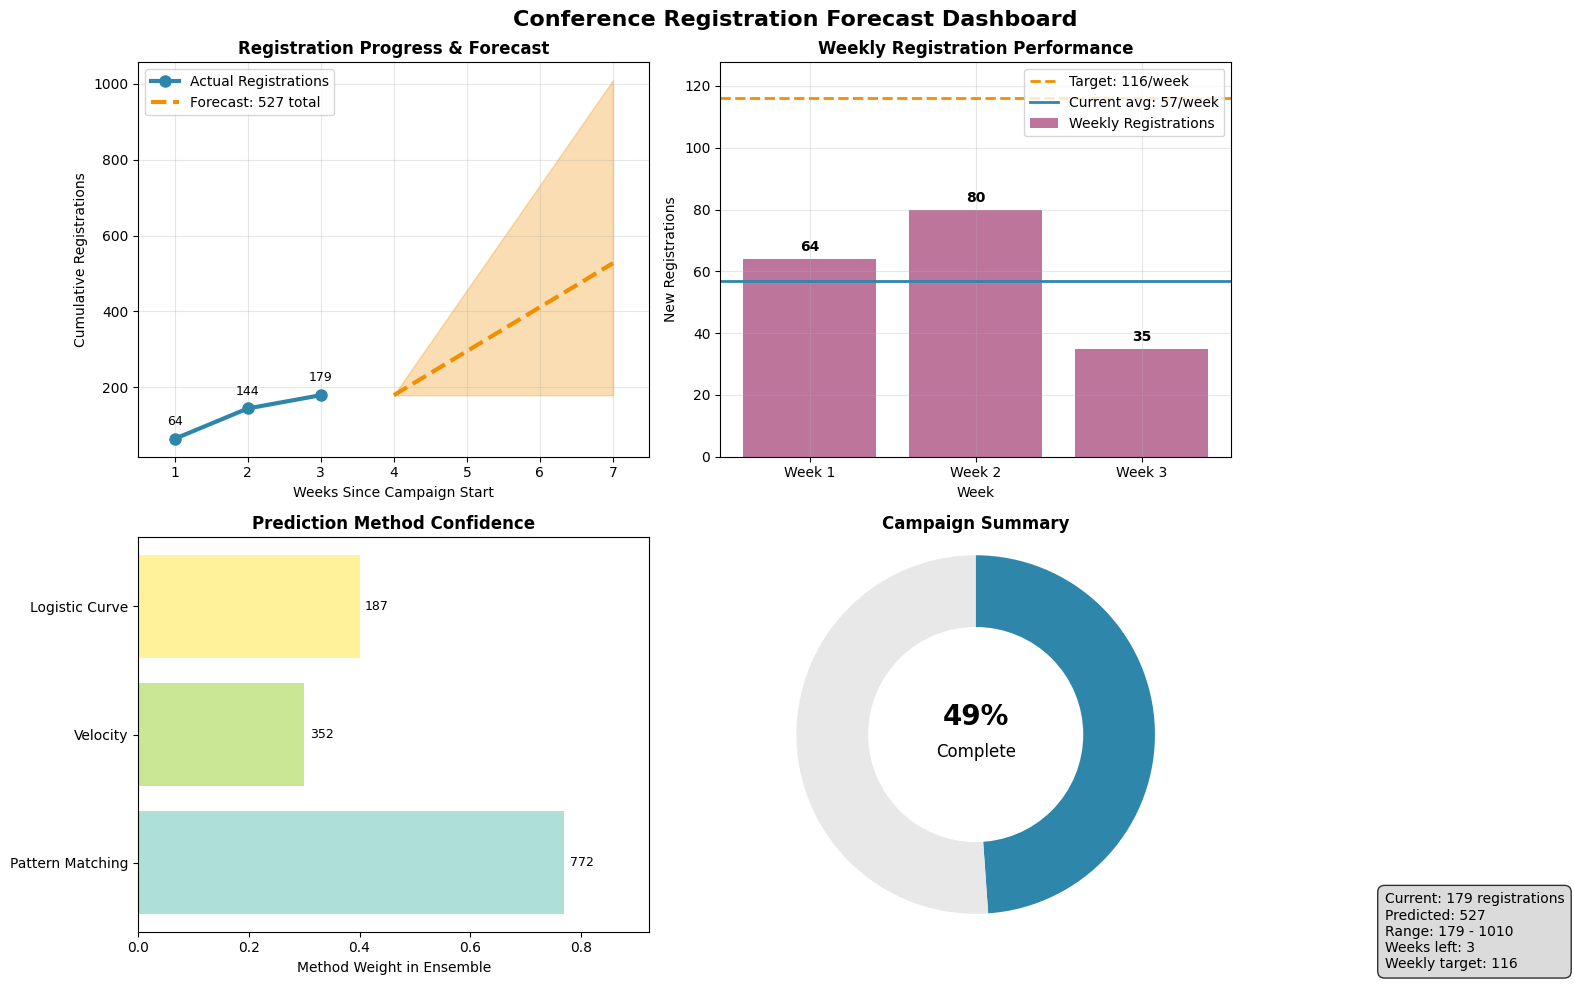


KEY INSIGHTS
Weekly Registration Data:
  Week 1: 64 new registrations (Total: 64)
  Week 2: 80 new registrations (Total: 144)
  Week 3: 35 new registrations (Total: 179)

Forecast Summary:
  Most likely final total: 527 registrations
  Weekly target needed: 116 registrations/week
  ⚠️ Acceleration needed: Current average is 57/week


In [8]:
# =============================================================================
# STREAMLINED VISUALIZATION DASHBOARD
# =============================================================================

def create_streamlined_dashboard(current_data: Dict, predictions: Dict, date_info: Dict, user_config: Dict):
    """Create a clean, focused visualization dashboard."""
    
    if 'error' in current_data or 'error' in predictions:
        print("Cannot create dashboard due to data errors")
        return
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 10))
    fig.suptitle('Conference Registration Forecast Dashboard', fontsize=16, fontweight='bold')
    
    # Panel 1: Registration Timeline & Forecast
    ax1.set_title('Registration Progress & Forecast', fontweight='bold', fontsize=12)
    
    current_weekly = current_data['weekly_data']
    weeks_elapsed = date_info['weeks_elapsed']
    weeks_remaining = date_info['weeks_remaining']
    total_weeks = weeks_elapsed + weeks_remaining
    
    # Current actual data
    if len(current_weekly) > 0:
        ax1.plot(current_weekly['Week'], current_weekly['CumulativeRegistrations'], 
                'o-', color='#2E86AB', linewidth=3, markersize=8, label='Actual Registrations')
        
        # Add data labels
        for _, row in current_weekly.iterrows():
            ax1.annotate(f'{int(row["CumulativeRegistrations"])}', 
                        (row['Week'], row['CumulativeRegistrations']), 
                        textcoords="offset points", xytext=(0,10), ha='center', fontsize=9)
    
    # Prediction line
    if weeks_remaining > 0:
        current_total = predictions['current_total']
        final_prediction = predictions['ensemble_prediction']
        
        # Forecast line
        future_weeks = np.array([weeks_elapsed, total_weeks])
        future_values = np.array([current_total, final_prediction])
        ax1.plot(future_weeks, future_values, '--', color='#F18F01', linewidth=3, 
                label=f'Forecast: {final_prediction:.0f} total')
        
        # Confidence band
        low_values = np.array([current_total, predictions['low_estimate']])
        high_values = np.array([current_total, predictions['high_estimate']])
        ax1.fill_between(future_weeks, low_values, high_values, alpha=0.3, color='#F18F01')
    
    ax1.set_xlabel('Weeks Since Campaign Start')
    ax1.set_ylabel('Cumulative Registrations')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    ax1.set_xlim(0.5, total_weeks + 0.5)  # Updated to start from 0.5 for 1-based weeks
    
    # Panel 2: Weekly Registration Rate
    ax2.set_title('Weekly Registration Performance', fontweight='bold', fontsize=12)
    
    if len(current_weekly) > 0:
        weeks = current_weekly['Week'].values
        registrations = current_weekly['Registrations'].values
        
        bars = ax2.bar(weeks, registrations, color='#A23B72', alpha=0.7, label='Weekly Registrations')
        
        # Add value labels on bars
        for i, (week, reg) in enumerate(zip(weeks, registrations)):
            ax2.text(week, reg + max(registrations) * 0.02, f'{int(reg)}', 
                    ha='center', va='bottom', fontweight='bold', fontsize=10)
        
        # Target weekly rate
        if weeks_remaining > 0:
            required_rate = predictions['additional_registrations_needed'] / weeks_remaining
            ax2.axhline(y=required_rate, color='#F18F01', linestyle='--', linewidth=2, 
                       label=f'Target: {required_rate:.0f}/week')
        
        # Current average
        avg_rate = current_data['avg_weekly_rate']
        ax2.axhline(y=avg_rate, color='#2E86AB', linestyle='-', linewidth=2, 
                   label=f'Current avg: {avg_rate:.0f}/week')
        
        ax2.set_ylim(0, max(max(registrations) * 1.3, required_rate * 1.1) if weeks_remaining > 0 else max(registrations) * 1.3)
        ax2.set_xticks(weeks)
        ax2.set_xticklabels([f'Week {int(w)}' for w in weeks])  # This already shows Week 1, 2, 3...
    
    ax2.set_xlabel('Week')
    ax2.set_ylabel('New Registrations')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # Panel 3: Prediction Methods Breakdown
    ax3.set_title('Prediction Method Confidence', fontweight='bold', fontsize=12)
    
    individual_preds = predictions['individual_predictions']
    if individual_preds:
        methods = [p['method'].replace('_', ' ').title() for p in individual_preds]
        weights = [p['weight'] for p in individual_preds]
        pred_values = [p['prediction'] for p in individual_preds]
        
        # Create color map
        colors = plt.cm.Set3(np.linspace(0, 1, len(methods)))
        
        bars = ax3.barh(methods, weights, color=colors, alpha=0.7)
        
        # Add prediction values as text
        for i, (method, weight, pred) in enumerate(zip(methods, weights, pred_values)):
            ax3.text(weight + 0.01, i, f'{pred:.0f}', va='center', fontsize=9)
        
        ax3.set_xlabel('Method Weight in Ensemble')
        ax3.set_xlim(0, max(weights) * 1.2)
    else:
        ax3.text(0.5, 0.5, 'No prediction methods available', ha='center', va='center', 
                transform=ax3.transAxes, fontsize=14)
    
    # Panel 4: Campaign Progress & Summary
    ax4.set_title('Campaign Summary', fontweight='bold', fontsize=12)
    
    # Progress donut chart
    completion_pct = date_info['completion_percentage']
    remaining_pct = 100 - completion_pct
    
    sizes = [completion_pct, remaining_pct]
    colors = ['#2E86AB', '#E8E8E8']
    
    wedges, texts = ax4.pie(sizes, colors=colors, startangle=90, counterclock=False)
    
    # Add center circle for donut effect
    centre_circle = plt.Circle((0,0), 0.6, fc='white')
    ax4.add_artist(centre_circle)
    
    # Add text in center
    ax4.text(0, 0.1, f'{completion_pct:.0f}%', ha='center', va='center', fontsize=20, fontweight='bold')
    ax4.text(0, -0.1, 'Complete', ha='center', va='center', fontsize=12)
    
    # Summary stats on the side
    summary_text = f"""Current: {predictions['current_total']} registrations
Predicted: {predictions['ensemble_prediction']:.0f}
Range: {predictions['low_estimate']:.0f} - {predictions['high_estimate']:.0f}
Weeks left: {weeks_remaining}
Weekly target: {predictions['additional_registrations_needed']/max(1, weeks_remaining):.0f}"""
    
    ax4.text(1.3, 0, summary_text, transform=ax4.transAxes, fontsize=10, 
            verticalalignment='center', 
            bbox=dict(boxstyle='round,pad=0.5', facecolor='lightgray', alpha=0.8))
    
    ax4.axis('equal')
    
    plt.tight_layout()
    plt.show()
    
    # Print key insights
    print("\n" + "=" * 50)
    print("KEY INSIGHTS")
    print("=" * 50)
    
    current_weekly_display = current_data['weekly_data']
    print("Weekly Registration Data:")
    for _, row in current_weekly_display.iterrows():
        week = int(row['Week'])
        registrations = int(row['Registrations'])
        cumulative = int(row['CumulativeRegistrations'])
        print(f"  Week {week}: {registrations} new registrations (Total: {cumulative})")
    
    print(f"\nForecast Summary:")
    print(f"  Most likely final total: {predictions['ensemble_prediction']:.0f} registrations")
    if weeks_remaining > 0:
        weekly_target = predictions['additional_registrations_needed'] / weeks_remaining
        print(f"  Weekly target needed: {weekly_target:.0f} registrations/week")
        
        current_avg = current_data['avg_weekly_rate']
        if weekly_target > current_avg * 1.2:
            print(f"  ⚠️ Acceleration needed: Current average is {current_avg:.0f}/week")
        else:
            print(f"  ✓ On track: Current average is {current_avg:.0f}/week")

# Create the streamlined dashboard
create_streamlined_dashboard(current_analysis, predictions, date_info, user_config)

In [9]:
# =============================================================================
# SYSTEM SUMMARY AND NEXT STEPS
# =============================================================================

def generate_actionable_summary(predictions: Dict, date_info: Dict, current_external_factors: Dict) -> None:
    """Generate actionable summary and recommendations."""
    
    print("\n" + "=" * 60)
    print("ACTIONABLE SUMMARY & NEXT STEPS")
    print("=" * 60)
    
    current_total = predictions['current_total']
    predicted_total = predictions['ensemble_prediction']
    weeks_remaining = date_info['weeks_remaining']
    
    # Performance assessment
    additional_needed = predictions['additional_registrations_needed']
    weekly_target = additional_needed / max(1, weeks_remaining)
    
    print(f"\n📊 Performance Status:")
    print(f"   Current registrations: {current_total}")
    print(f"   Predicted final total: {predicted_total:.0f}")
    print(f"   Confidence range: {predictions['low_estimate']:.0f} - {predictions['high_estimate']:.0f}")
    
    print(f"\n🎯 Action Required:")
    print(f"   Additional registrations needed: {additional_needed:.0f}")
    print(f"   Weekly target for remaining {weeks_remaining} weeks: {weekly_target:.0f} registrations/week")
    
    # Risk level assessment
    current_avg = weekly_target
    if additional_needed <= 0:
        risk_level = "✅ LOW RISK"
        print(f"\n{risk_level}: Already on track to meet targets")
    elif weekly_target <= current_avg * 1.2:
        risk_level = "🟡 MODERATE RISK"  
        print(f"\n{risk_level}: Need to maintain or slightly increase current pace")
    else:
        risk_level = "🔴 HIGH RISK"
        print(f"\n{risk_level}: Significant acceleration required")
    
    # External factors
    if 'error' not in current_external_factors:
        if current_external_factors.get('warnings'):
            print(f"\n⚠️ External Factors to Consider:")
            for warning in current_external_factors['warnings']:
                print(f"   • {warning}")
    
    # Recommendations
    print(f"\n💡 Recommended Actions:")
    if weeks_remaining <= 2:
        print(f"   • URGENT: Implement intensive last-minute push campaign")
        print(f"   • Consider direct outreach to warm leads")
    elif additional_needed > current_total * 0.5:
        print(f"   • Boost marketing spend and channels")
        print(f"   • Review and optimize conversion funnel")
    else:
        print(f"   • Maintain current marketing strategy")
        print(f"   • Monitor weekly performance against targets")
    
    print(f"\n📈 Key Success Metrics to Track:")
    print(f"   • Weekly registration rate (target: {weekly_target:.0f}/week)")
    print(f"   • Registration velocity trends")
    print(f"   • Marketing channel performance")

# Generate the summary
generate_actionable_summary(predictions, date_info, current_external_factors)

print("\n" + "=" * 60)
print("SYSTEM READY FOR REAL-TIME UPDATES")
print("=" * 60)
print("To update forecasts with new registration data:")
print("1. Replace 'sample_data.csv' with latest registration data")
print("2. Update event_date, marketing_start_date in cell-3 if needed") 
print("3. Run all cells to get updated predictions")
print("\nThe system automatically:")
print("✓ Accounts for UK bank holidays and COVID-like disruptions")
print("✓ Provides accurate weekly registration tracking and analysis")
print("✓ Uses proven forecasting methods (pattern matching, velocity, curve fitting)")
print("✓ Generates actionable insights and recommendations")


ACTIONABLE SUMMARY & NEXT STEPS

📊 Performance Status:
   Current registrations: 179
   Predicted final total: 527
   Confidence range: 179 - 1010

🎯 Action Required:
   Additional registrations needed: 348
   Weekly target for remaining 3 weeks: 116 registrations/week

🟡 MODERATE RISK: Need to maintain or slightly increase current pace

⚠️ External Factors to Consider:
   • Short timeline - limited adjustment time for external factors

💡 Recommended Actions:
   • Boost marketing spend and channels
   • Review and optimize conversion funnel

📈 Key Success Metrics to Track:
   • Weekly registration rate (target: 116/week)
   • Registration velocity trends
   • Marketing channel performance

SYSTEM READY FOR REAL-TIME UPDATES
To update forecasts with new registration data:
1. Replace 'sample_data.csv' with latest registration data
2. Update event_date, marketing_start_date in cell-3 if needed
3. Run all cells to get updated predictions

The system automatically:
✓ Accounts for UK bank h